# Sentiment Analysis on Movie Reviews

## About the dataset

The dataset consists of 40,000 movie reviews. The reviews are all long sentences(Most of them being above 200 words) 

**Task** : The task is to analyze the reviews and to predict whether they are positive or negative. 

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import os 
from collections import Counter
from tqdm.notebook import tqdm
from sklearn import preprocessing
from bs4 import BeautifulSoup
import re 
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.auto import tqdm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
import tensorflow as tf 
warnings.filterwarnings("ignore")

In [10]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155320 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [11]:
#Reading our Training Dataset
data = pd.read_csv('/content/drive/MyDrive/Train.csv')

In [13]:
data.head()

text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1

In [14]:
data.shape

(40000, 2)

There are 40000 reviews and their corresponding labels(positive or negative). 0 indicates negative and 1 indicates positive

In [15]:
data.isna().sum()

text     0
label    0
dtype: int64

There are no missing values

# Text Preprocessing

We intend to clean the text by  
1) removing stopwords  
2) Dealing with auxillaries by seperating 'nots'  
3) Removing HTML tags (bs4 library is used for this)   
4) Removing special charecters and digits   
5) Converting the words into lower case  


In [16]:

#stopwords  like not,nor etc. which could influence the sentiment label, were removed from the stopwords list.
stopword= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])
#dealing with auxialaries
def seperate_nots(text):
  text = re.sub("can't",'can not',text) 
  text = re.sub("shan't",'shall not',text)
  text = re.sub("won't",'will not',text)
  text = re.sub("n't",' not',text) 
  text = re.sub("'re",' are',text)
  text = re.sub("'ve",' have',text) 
  text = re.sub("'m",' am',text)
  text = re.sub("'ll",' will',text)
  text = re.sub("'d",' would',text)
  text = re.sub("'s",' is',text) 
  return text

def preprocessing_text(text,stopword):
  lst = []
  text = BeautifulSoup(text, "lxml").text #code for removing html tags 
  text = re.sub('[^a-z A-Z0-9]+','',text) #removing special characters 
  text = re.sub('(\S*\d\S*)','',text).strip() #removing numbers/digits
  text = re.sub('"http:\S+"', '',text) 
  text = seperate_nots(text)
  for word in text.split():
    if word not in stopword:
      l = word.lower() 
      lst.append(l) 
      x = ' '.join(lst)
  return x

In [17]:
data['text'][0]

'I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.'

In [18]:
preprocessing_text(data['text'][0],stopword)

'i grew b watching loving thunderbirds all mates school watched we played thunderbirds school lunch school we wanted virgil scott no one wanted alan counting became art form i took children see movie hoping would get glimpse i loved child how bitterly disappointing the high point snappy theme tune not could compare original score thunderbirds thankfully early saturday mornings one television channel still plays reruns series gerry anderson wife created jonatha frakes hand directors chair version completely hopeless a waste film utter rubbish a cgi remake may acceptable replacing marionettes homo sapiens subsp sapiens huge error judgment'

In [19]:
data['text'] = data['text'].apply(lambda x: preprocessing_text(x,stopword))

In [20]:
data.to_csv('clean_data.csv',index=False) #saving the clean data

In [21]:
data = pd.read_csv('/content/drive/MyDrive/clean_data.csv')

In [22]:
data.head()

text  label
0  i grew b watching loving thunderbirds all mate...      0
1  when i put movie dvd player sat coke chips i e...      0
2  why people not know particular time past like ...      0
3  even though i great interest biblical movies i...      0
4  im die hard dads army fan nothing ever change ...      1

In [23]:
data.shape

(40000, 2)

Checking the nature of dataset. How many positive/negative reviews?

0    20019
1    19981
Name: label, dtype: int64


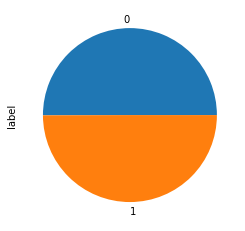

In [24]:
print(data['label'].value_counts())
data['label'].value_counts().plot(kind='pie')

The data is balanced. We have fairly equal amount of positive and negative reviews 

A Wordcloud of all the reviews : 

There are 34911148 words in the combination of all review.


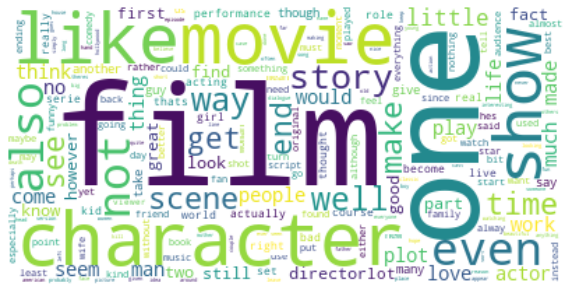

In [ ]:
text = " ".join(review for review in data.text)
print ("There are {} words in the combination of all review.".format(len(text))) 
plt.figure(figsize=(10,7))
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopword,background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

There are 17751882 words in the combination of all positive reviews.


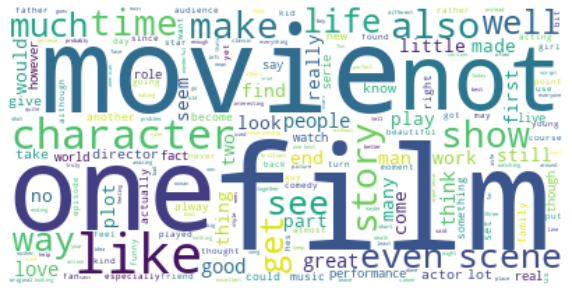

In [ ]:
data_pos = data[data['label'] == 1]
text = " ".join(review for review in data_pos.text)
print ("There are {} words in the combination of all positive reviews.".format(len(text))) 
plt.figure(figsize=(10,7))
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopword,background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

There are 17159265 words in the combination of all negative reviews.


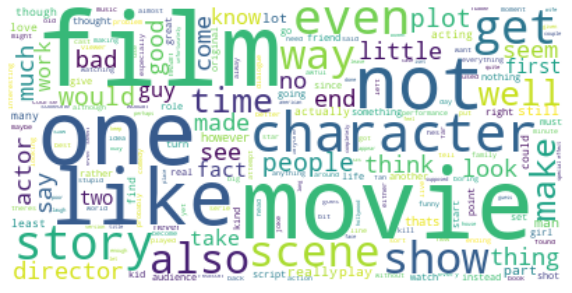

In [ ]:
data_neg = data[data['label'] == 0]
text = " ".join(review for review in data_neg.text)
print ("There are {} words in the combination of all negative reviews.".format(len(text))) 
plt.figure(figsize=(10,7))
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopword,background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Count Vectorizer - Bag of words

In [26]:
countvec = CountVectorizer(ngram_range=(1,1))  
countvec.fit(data['text']) 
print("Printing Some Features: ", countvec.get_feature_names()[0:10]) 
final_countvec = countvec.transform(data['text']) 
print('The type of tfidf matrix: ', type(final_countvec)) 
print('The shape of tfidf matrix: ',final_countvec.get_shape()) 
print('The number of unique values: ',final_countvec.get_shape()[1])

Printing Some Features:  ['aa', 'aaa', 'aaaaaaaaaaaahhhhhhhhhhhhhh', 'aaaaaaaargh', 'aaaaaaah', 'aaaaaaahhhhhhggg', 'aaaaagh', 'aaaaah', 'aaaaargh', 'aaaaarrrrrrgggggghhhhhh']
The type of tfidf matrix:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of tfidf matrix:  (40000, 185871)
The number of unique values:  185871


In [27]:
y=data.label.values #converting the label column into an array
x=final_countvec

In [28]:
y

array([0, 0, 0, ..., 0, 1, 1])

#### Train Test Split

In [63]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [64]:
X_cv,X_test,y_cv,y_test=train_test_split(X_train,y_train,test_size=0.2)

In [65]:
print("The shape of X_train: ",X_train.shape) 
print("The shape of y_train: ",y_train.shape) 
print("The shape of X_test: ",X_test.shape) 
print("The shape of y_test: ",y_test.shape) 

The shape of X_train:  (32000, 185871)
The shape of y_train:  (32000,)
The shape of X_test:  (6400, 185871)
The shape of y_test:  (6400,)


# Model Building

Various Classification models are implemented below. The motive is to find the good classifiers with a reasonably good accuracy score. 

#### Decision Tree Classifier

In [36]:
clf=DecisionTreeClassifier(criterion='gini').fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [37]:
from sklearn import metrics
print("Accuracy on Decision Tree:",metrics.accuracy_score(y_test, y_pred))

Accuracy on Decision Tree: 0.719125


In [38]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.72      0.72      3968
           1       0.72      0.72      0.72      4032

    accuracy                           0.72      8000
   macro avg       0.72      0.72      0.72      8000
weighted avg       0.72      0.72      0.72      8000



In [39]:
print(confusion_matrix(y_test,y_pred))

[[2866 1102]
 [1145 2887]]


#### K Nearest Neighbours

In [40]:
clf=KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [41]:
from sklearn import metrics
print("Accuracy on KNN:",metrics.accuracy_score(y_test, y_pred))

Accuracy on KNN: 0.605375


In [42]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.58      0.70      0.64      3968
           1       0.64      0.51      0.56      4032

    accuracy                           0.61      8000
   macro avg       0.61      0.61      0.60      8000
weighted avg       0.61      0.61      0.60      8000



In [43]:
print(confusion_matrix(y_test,y_pred))

[[2795 1173]
 [1984 2048]]


#### Random Forest Classifier

In [44]:
clf=RandomForestClassifier(n_estimators=600,n_jobs=-1,max_depth=2).fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [45]:
from sklearn import metrics
print("Accuracy on RFC:",metrics.accuracy_score(y_test, y_pred))

Accuracy on RFC: 0.818125


In [46]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.87      0.83      3968
           1       0.86      0.76      0.81      4032

    accuracy                           0.82      8000
   macro avg       0.82      0.82      0.82      8000
weighted avg       0.82      0.82      0.82      8000



In [48]:
print(confusion_matrix(y_test,y_pred))

[[3471  497]
 [ 958 3074]]


#### Gradient Boosting Classifier

In [ ]:
gbc=GradientBoostingClassifier(n_estimators=200,learning_rate=0.1,max_depth=2) 
gbc.fit(X_train,y_train)
ypred = gbc.predict(X_test) 

In [ ]:
from sklearn import metrics
print("Accuracy on GradientBoostingClassifier: ",metrics.accuracy_score(y_test, ypred))

Accuracy on GradientBoostingClassifier:  0.8135


In [ ]:
print(classification_report(y_test,ypred))

              precision    recall  f1-score   support

           0       0.85      0.76      0.80      4000
           1       0.78      0.87      0.82      4000

    accuracy                           0.81      8000
   macro avg       0.82      0.81      0.81      8000
weighted avg       0.82      0.81      0.81      8000



In [ ]:
print(confusion_matrix(y_test,ypred))

[[3045  955]
 [ 537 3463]]


#### Multinomial Naive Bayes Classifier

In [50]:
MNB = MultinomialNB().fit(X_train,y_train)
y_pred = MNB.predict(X_test)

In [51]:
from sklearn import metrics
print("Accuracy on Naive_Bayes:",metrics.accuracy_score(y_test, y_pred))

Accuracy on Naive_Bayes: 0.85575


In [52]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      3968
           1       0.87      0.83      0.85      4032

    accuracy                           0.86      8000
   macro avg       0.86      0.86      0.86      8000
weighted avg       0.86      0.86      0.86      8000



In [53]:
print(confusion_matrix(y_test,y_pred))

[[3480  488]
 [ 666 3366]]


#### Logistic Regression

In [ ]:
clf=LogisticRegressionCV(cv=10,scoring='accuracy',n_jobs=-1,verbose=1,max_iter=500)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  1.7min remaining:   25.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished


In [ ]:
from sklearn.linear_model import LogisticRegression
params = clf.get_params()
params

{'Cs': 10,
 'class_weight': None,
 'cv': 10,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': None,
 'refit': True,
 'scoring': 'accuracy',
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 1}

In [54]:
clf2 = LogisticRegression(dual=False,max_iter=500,n_jobs=-1,penalty='l2',solver='lbfgs',tol=0.0001,verbose=1)
clf2.fit(X_train,y_train)
y_pred = clf2.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.1s finished


In [55]:
from sklearn import metrics
print("Accuracy on Logistic Regression: ",metrics.accuracy_score(y_test, y_pred))

Accuracy on Logistic Regression:  0.8805


In [56]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      3968
           1       0.88      0.88      0.88      4032

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000



In [57]:
cm=confusion_matrix(y_test,y_pred)

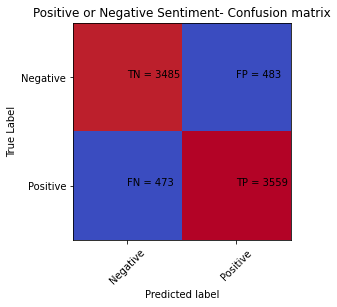

In [58]:
plt.clf() 
plt.imshow(cm,interpolation='nearest',cmap='coolwarm') 
classnames = ['Negative','Positive'] 
tick_marks = np.arange(len(classnames)) 
plt.ylabel('True Label') 
plt.xlabel('Predicted label') 
plt.title('Positive or Negative Sentiment- Confusion matrix')
plt.xticks(tick_marks,classnames,rotation=45) 
plt.yticks(tick_marks,classnames) 
S = [['TN',"FP"],['FN','TP']] 
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(S[i][j])+" = "+str(cm[i][j])) 
plt.show()

In [ ]:
import pickle
pickle.dump(clf,open('/content/drive/MyDrive/LR movie.pkl','wb'))
pickle.dump(countvec,open('/content/drive/MyDrive/countvec movie.pkl','wb'))

Testing the model by giving it an input review

In [60]:
a = ["I cannot phrase it better, so I will quote Rex Reed who called Inception's storyline prattling drivel. A friend claimed Inception is a thinking person's movie, but a thinking person will realize that it is only masquerading as a thinking person's movie. At bottom, intellectually, there is no there there. Add to this that someone clearly believed the film needed to be pumped up with overwrought drama to qualify it as a summer blockbuster. I couldn't wait for it to end, and when it did, the intrusiveness of the loud, schlocky music over the closing credits seemed to crystallize all the incipient negative feelings I had been having throughout the movie. I hope that this director will go back to doing smaller films that do not stretch his concepts beyond what they can support."]
a = countvec.transform(a).toarray()

In [61]:
MNB.predict(a)

array([0])

#### Deep learning model

In [66]:
X_train.shape

(32000, 185871)

In [67]:
#NN

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(512, input_dim=185871, activation='relu'))
model.add(tf.keras.layers.Dense(368, activation='relu'))
model.add(tf.keras.layers.Dense(356, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [68]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               95166464  
                                                                 
 dense_1 (Dense)             (None, 368)               188784    
                                                                 
 dense_2 (Dense)             (None, 356)               131364    
                                                                 
 dense_3 (Dense)             (None, 128)               45696     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 95,540,629
Trainable params: 95,540,629
No

In [69]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [70]:
model.fit(X_train,y_train, epochs=5,batch_size=10,validation_data=(X_cv,y_cv))

Epoch 1/5
3200/3200 [==============================] - 1090s 340ms/step - loss: 0.3246 - accuracy: 0.8657 - val_loss: 0.1287 - val_accuracy: 0.9674
Epoch 2/5
3200/3200 [==============================] - 1071s 335ms/step - loss: 0.1118 - accuracy: 0.9635 - val_loss: 0.0389 - val_accuracy: 0.9919
Epoch 3/5
3200/3200 [==============================] - 1082s 338ms/step - loss: 0.0379 - accuracy: 0.9908 - val_loss: 0.0207 - val_accuracy: 0.9969
Epoch 4/5
3200/3200 [==============================] - 1081s 338ms/step - loss: 0.0197 - accuracy: 0.9958 - val_loss: 0.0103 - val_accuracy: 0.9986
Epoch 5/5
3200/3200 [==============================] - 1083s 338ms/step - loss: 0.0155 - accuracy: 0.9971 - val_loss: 0.0092 - val_accuracy: 0.9986


In [71]:
acc = model.evaluate(X_test,y_test)

200/200 [==============================] - 3s 13ms/step - loss: 0.0081 - accuracy: 0.9989


In [72]:
print("The loss and Accuracy are respectively: ")
acc

The loss and Accuracy are respectively: 


[0.008132086135447025, 0.9989062547683716]

Testing the Model by giving it an input review

In [74]:
review = "The movie was the best i have seen in a long time. Good acting"
review = [preprocessing_text(review,stopword)]
review = countvec.transform(review).toarray()
pred = model.predict(review)
if pred <= 0.50:
  print('Negative')
else:
  print('Positive')

Positive


Conclusion: 
After implementing various models, We arrive at the conclusion that the following three are giving the best results:  
1)Deep Learning tenserflow keras-->   Accuracy_Score : 99.98%  
2)Logistic Regression-->   Accuracy_Score : 88.59%   
3)Multinomial Naive Bayes-->  Accuracy_Score: 85.73%  